Task : Coronavirus tweets NLP - Text Classification <br>
URL : https://www.kaggle.com/datatattle/covid-19-nlp-text-classification <br>
Author : Siddarthan <br>
Description : This notebook contains the pipeline to preprocess covid NLP data, vectorize the data using TF-IDF and hash based embeddings and train Machine Learning models using the data. The models in this notebook is just for baseline, they are not the final models. <br>
Created on : 15-11-2021 <br>
Updated on : 16-11-2021 <br>


In [1]:
# Import required packages

import pandas as pd
import numpy as np
import torch
import nltk
import re

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torch import nn

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB # Suitable for discrete data

from xgboost import XGBClassifier

In [2]:
# Path to csv files

train_file = "../input/covid-19-nlp-text-classification/Corona_NLP_train.csv"
test_file = "../input/covid-19-nlp-text-classification/Corona_NLP_test.csv"

In [3]:
# Select device gpu/cpu

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Exploration


In [4]:
# Read the csv files
train_data = pd.read_csv(train_file, encoding='latin1')
test_data = pd.read_csv(test_file, encoding='latin1')

In [5]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


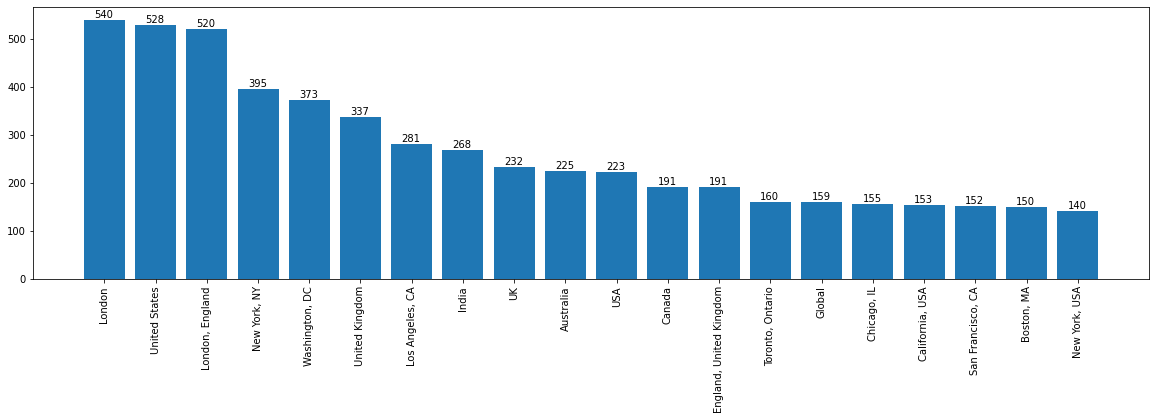

In [7]:
# Top locations of the tweets
location = train_data['Location'].value_counts().nlargest(20)
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(location.index, location.values)
plt.xticks(location.index, rotation='vertical')
for idx, val in enumerate(location):
    plt.text(idx-0.2, val+5, str(val))
plt.show()

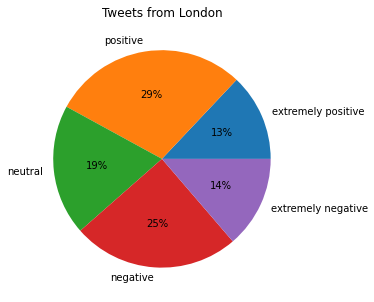

In [8]:
# Tweets originated from London (Top location)
extreme_positive_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Extremely Positive")])
positive_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Positive")])
neutral_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Neutral")])
negative_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Negative")])
extreme_negative_tweets = len(train_data[(train_data["Location"] == "London") & (train_data["Sentiment"] == "Extremely Negative")])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Tweets from London")
plt.show()


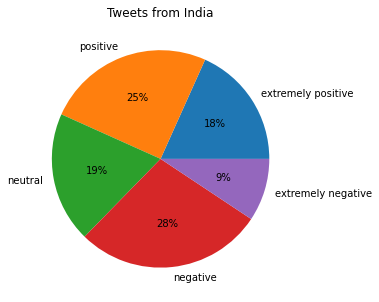

In [9]:
# Tweets originated from India
extreme_positive_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Extremely Positive")])
positive_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Positive")])
neutral_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Neutral")])
negative_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Negative")])
extreme_negative_tweets = len(train_data[(train_data["Location"] == "India") & (train_data["Sentiment"] == "Extremely Negative")])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Tweets from India")
plt.show()

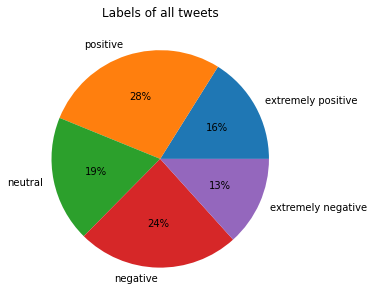

In [10]:
# Tweets originated from all locations
extreme_positive_tweets = len(train_data[train_data["Sentiment"] == "Extremely Positive"])
positive_tweets = len(train_data[train_data["Sentiment"] == "Positive"])
neutral_tweets = len(train_data[train_data["Sentiment"] == "Neutral"])
negative_tweets = len(train_data[train_data["Sentiment"] == "Negative"])
extreme_negative_tweets = len(train_data[train_data["Sentiment"] == "Extremely Negative"])

labels = ["extremely positive", "positive", "neutral", "negative", "extremely negative"]
plt.pie([extreme_positive_tweets, positive_tweets, neutral_tweets, negative_tweets, extreme_negative_tweets],
        labels=labels, autopct='%1.0f%%')
plt.title("Labels of all tweets")
plt.show()

In [11]:
# Check for missing values in training data
train_data.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [12]:
# Check for missing values in test data
test_data.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [13]:
# Check for duplicate tweets
print("Total tweets", len(train_data["OriginalTweet"]))
print("Unique tweets", len(set(train_data["OriginalTweet"])))

Total tweets 41157
Unique tweets 41157


The following observations were obtained from data exploration

1. The data under the header 'OriginalTweet' can be used as input data.
2. The data under the header 'Sentiment' can be used as the labels to predict.
3. The other columns can be removed.
4. Missing values are present only in the 'Location' column which is removed.
5. No duplicate tweets are found.
6. Five sentiments are labelled namely neutral, positive, extremely positive, negative and extremely negative
7. Sentiments can be reduced to three <br>
   a. positive (positive + extremely positive) <br>
   b. negative (negative + extremely negative) <br>
   c. neutral <br>
   (Positive and extremely positive will have similar context hence may not be differentiated easily by the model and it is the same for negative and extremely negative)

# Data Cleaning and transformation

In [14]:
# Filter the required columns

train_data = train_data[["OriginalTweet", "Sentiment"]]
test_data = test_data[["OriginalTweet", "Sentiment"]]

## Sentiment label preparation

In [15]:
train_data["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [16]:
test_data["Sentiment"].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

#### Positive and Extremely positive can be combined to a same class. Negative and Extremely negative can be combined to a same class.
#### This is due to the following reasons
1. Number of samples in each class in less. Hence the model may not learn the features properly
2. The context of Positive and Extremely positive samples will be similar. Hence the model may not differentiate between them. (A more complex model with more number of samples will be required to differentiate properly)

In [17]:
# Dictionary of labels and their integer values
label_index = {
    "Positive" : 0,
    "Negative" : 1,
    "Neutral"  : 2,
    "Extremely Positive" : 0,
    "Extremely Negative" : 1
}

In [18]:
# Convert the training labels to tensor values
train_y = []
for label in train_data["Sentiment"]:
    train_y.append(torch.tensor([label_index[label]], dtype=torch.long, device=device))

In [19]:
# Convert the test labels to tensor values
test_y = []
for label in test_data["Sentiment"]:
    test_y.append(torch.tensor([label_index[label]], dtype=torch.long, device=device))

3
{0: 0.7602238723262773, 1: 0.8909598649175218, 2: 1.778685336444963}


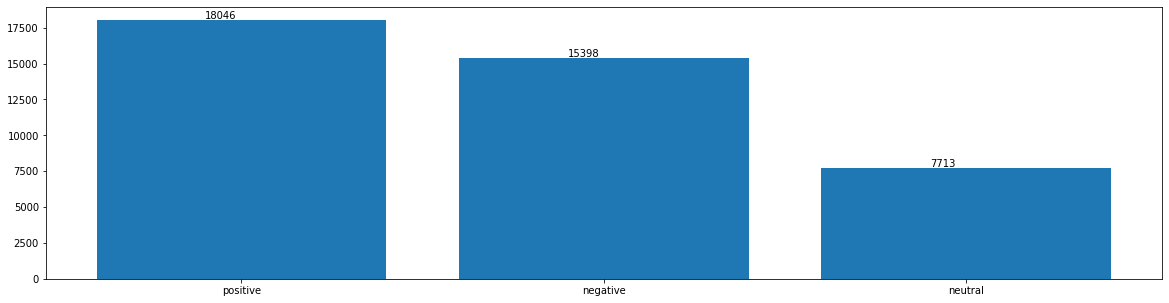

In [20]:
# Number of classes in the data
n_classes = len(set([item.item() for item in train_y]))
print(n_classes)

# Calculate class weights
labels = [label.item() for label in train_y]
class_weights = dict(zip(np.unique(labels), compute_class_weight("balanced", classes=np.unique(labels), y=labels)))
print(class_weights)

# Number of samples in each class
plt.bar(["positive", "negative", "neutral"],[labels.count(0), labels.count(1), labels.count(2)])
for idx, val in enumerate([labels.count(0), labels.count(1), labels.count(2)]):
    plt.text(idx-0.1, val+100, str(val))
plt.show()

#### From the data distribution, we can say that the model may learn the positive and negative samples properly since they are more in number compared to the neutral samples
#### Due to class imbalance, we can use class weights while calculating loss to given more importance to class with less number of samples


## Input data preparation

### Data Cleaning

Data cleaning techniques used
1. Removing urls since url does not contain any relevant information
2. Remove emoji and symbols
3. Expand words Ex. shouldn't -> should not - this will avoid duplicate embeddings (different embeddings for shouldn't and should not will affect the model performance)
4. Separate alphabets and numbers - it will split texts like 'abcd123' to 'abc', '123'
5. Truncate repeated single characters
6. Remove special characters - it will remove @ and # symbols that are commonly used in tweets
7. Convert to lower case

In [21]:
# Clean text

def remove_url(text):
    """
    Function to remove URL from the data
    """
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_emoji(text):
    """
    Function to remove the emojis from the data
    Ref : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    """

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def expand(text):
    """
    Function to expand the words commonly used in English
    """
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text

def seperate_alphanumeric(text):
    """
    Function to separate alphabets and numbers that are found together
    in the text
    """
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)
    
def cont_rep_char(text):
    """
    Find repeating character
    """
    tchr = text.group(0)
    if len(tchr) > 1:
        return tchr[0:2]
    
def unique_char(rep, text):
    """
    Substitue repeating character with rep in text
    """
    sub = re.sub(r'(\w)\1+', rep, text)
    return sub

def special_char(text):
    """
    Remove special characters other than alphabets
    """
    return re.sub(r'[^a-zA-Z]',' ',text)

# Apply functions on the training data
train_data['OriginalTweet'] = [remove_url(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [remove_emoji(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [expand(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [seperate_alphanumeric(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [unique_char(cont_rep_char, data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [special_char(data) for data in train_data['OriginalTweet']]
train_data['OriginalTweet'] = [data.lower() for data in train_data['OriginalTweet']]

# Apply functions on the test data
test_data['OriginalTweet'] = [remove_url(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [remove_emoji(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [expand(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [seperate_alphanumeric(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [unique_char(cont_rep_char, data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [special_char(data) for data in test_data['OriginalTweet']]
test_data['OriginalTweet'] = [data.lower() for data in test_data['OriginalTweet']]


# TF-IDF

### Data Vectorization

#### Main Objective of this step is to convert the sequence to tokens to feature vector of fixed size

The following steps are carried out
1. The input sequence is tokenized and lemmatized
2. The lemmatized sequence is vectorized using TF-IDF

We will obtain
1. Vectorized training data of fixed size
2. Vectorized test data of fixed size

In [22]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=300)

In [23]:
# Initialize the Lemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
# Tokenize and lemmatize the tweets in training data
train_X = []

for tweet in tqdm(train_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    for i in range(len(tokens)):
        tokens[i] = lemmatizer.lemmatize(tokens[i])
    train_X.append(' '.join(tokens))


100%|██████████| 41157/41157 [00:14<00:00, 2832.00it/s]


In [25]:
# Tokenize and lemmatize the tweets in the test data
test_X = []

for tweet in tqdm(test_data["OriginalTweet"]):
    tokens = word_tokenize(tweet)
    for i in range(len(tokens)):
        tokens[i] = lemmatizer.lemmatize(tokens[i])
    test_X.append(' '.join(tokens))

100%|██████████| 3798/3798 [00:01<00:00, 3075.05it/s]


In [26]:
# Encode the data using TF-IDF vectorizer
encoded_train_X = vectorizer.fit_transform(train_X)
encoded_test_X = vectorizer.transform(test_X)
print(encoded_train_X.shape, encoded_test_X.shape)

(41157, 300) (3798, 300)


## Model training

#### The following machine learning models are trained using the vectorized data
1. Multinomial Naive Bayes
2. Decision Tree Classifier
3. Random Forest Classifier
4. XGBoost Classifier
5. Extra Trees Classifier

In [27]:
# Place holders to store the results
tfidf_accuracy = {}
tfidf_f1 = {}

In [28]:
# Train Multinomial Naive Bayes model
model = MultinomialNB()
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store results
report = classification_report(test_y, pred_y, output_dict=True)
tfidf_accuracy["MutinomialNB"] = report["accuracy"]
tfidf_f1["MutinomialNB"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.53      0.80      0.64      1546
           1       0.66      0.57      0.61      1633
           2       0.71      0.06      0.12       619

    accuracy                           0.58      3798
   macro avg       0.64      0.48      0.46      3798
weighted avg       0.62      0.58      0.54      3798



In [29]:
# Train Decision Tree classifier model
model = DecisionTreeClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
tfidf_accuracy["DecisionTreeClassifier"] = report["accuracy"]
tfidf_f1["DecisionTreeClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      1546
           1       0.58      0.54      0.56      1633
           2       0.36      0.43      0.39       619

    accuracy                           0.52      3798
   macro avg       0.50      0.50      0.50      3798
weighted avg       0.53      0.52      0.53      3798



In [30]:
# Train Random Forest Model
model = RandomForestClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
tfidf_accuracy["RandomForestClassifier"] = report["accuracy"]
tfidf_f1["RandomForestClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.58      0.70      0.63      1546
           1       0.66      0.58      0.62      1633
           2       0.55      0.46      0.50       619

    accuracy                           0.61      3798
   macro avg       0.60      0.58      0.58      3798
weighted avg       0.61      0.61      0.60      3798



In [31]:
# Train XGBoost Model
model = XGBClassifier(use_label_encoder=False)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
tfidf_accuracy["XGBClassifier"] = report["accuracy"]
tfidf_f1["XGBClassifier"] = report["macro avg"]['f1-score']

[07:10:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.62      0.70      0.66      1546
           1       0.69      0.61      0.65      1633
           2       0.51      0.51      0.51       619

    accuracy                           0.63      3798
   macro avg       0.61      0.61      0.61      3798
weighted avg       0.63      0.63      0.63      3798



In [32]:
# Train Extra Trees classifier model
model = ExtraTreesClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))
, 
# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
tfidf_accuracy["ExtraTreesClassifier"] = report["accuracy"]
tfidf_f1["ExtraTreesClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1546
           1       0.66      0.63      0.64      1633
           2       0.55      0.44      0.49       619

    accuracy                           0.62      3798
   macro avg       0.61      0.59      0.59      3798
weighted avg       0.62      0.62      0.62      3798



## Neural network training

#### A simple neural network with one hidden layer is trained using the vectorized data

In [33]:
# Convert the data to tensors
tensor_train_X = torch.tensor(encoded_train_X.toarray(), dtype=torch.float, device=device)
tensor_test_X = torch.tensor(encoded_test_X.toarray(), dtype=torch.float, device=device)

In [34]:
class TfIdfClassifier(nn.Module):
  """
  Covid tweet classifer for TF-IDF vectorized data
  """
  def __init__(self, embedding_size, hidden_size=50, n_class=3):
    """
    Intialize the hidden layers
    """
    super().__init__()
    self.fc = nn.Linear(embedding_size, hidden_size)
    self.act = nn.ReLU()
    self.out = nn.Linear(hidden_size, n_class)

  def forward(self, data):
    """
    Pass the input through the model and return the output tensor
    """
    out = self.act(self.fc(data))
    out = self.out(out)

    return out

In [35]:
# Intialize the model, loss function and optimizer

learning_rate = 0.001
n_epochs = 100
test_interval = 1

classifier_tfidf = TfIdfClassifier(encoded_train_X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
optimizer = torch.optim.Adam(classifier_tfidf.parameters(), lr=learning_rate)

In [36]:
# Placeholders to store model progress
train_loss = []
train_accuracy = []
train_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []

pbar = tqdm(range(1, n_epochs+1))
for epoch in pbar:

    ##########
    # TRAINING
    ##########

    classifier_tfidf.train()
    
    # Get the model output
    out = classifier_tfidf(tensor_train_X)
    pred_values = torch.argmax(out, dim=1)

    # Calculate the loss
    loss = criterion(out, torch.tensor(train_y))
    
    # Store the training metrics
    train_loss.append(loss.detach().item())
    train_accuracy.append(accuracy_score(train_y, pred_values))
    train_f1.append(f1_score(train_y, pred_values, average='macro'))
    
    # Update the model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # print the progress
    pbar.set_description(f"Epoch:{epoch} Training loss:{round(train_loss[-1], 5)} " +
                                 f"accuracy:{round(train_accuracy[-1], 5)} " +
                                 f"f1 score:{round(train_f1[-1], 5)}")
      
    
    

    ############
    # VALIDATION
    ############
    if epoch % test_interval == 0:

        classifier_tfidf.eval()
        with torch.no_grad():
            
            # Get the model output
            out = classifier_tfidf(tensor_test_X)
            pred_values = torch.argmax(out, dim=1)

            # Calculate the loss
            loss = criterion(out, torch.tensor(test_y))
            
            # Store the test metrics
            test_loss.append(loss.detach().item())
            test_accuracy.append(accuracy_score(test_y, pred_values))
            test_f1.append(f1_score(test_y, pred_values, average='macro'))


Epoch:100 Training loss:0.91542 accuracy:0.57871 f1 score:0.56866: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


### Loss graph

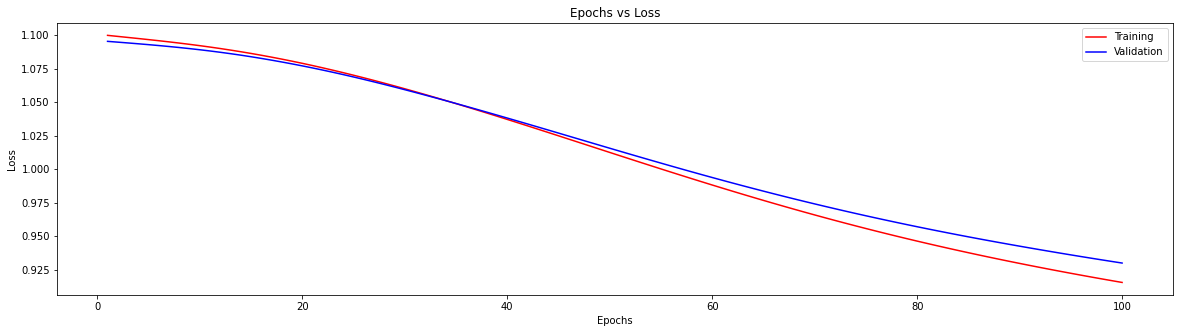

In [37]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_loss, "red")
plt.plot(test_epochs, test_loss, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.show()

### Accuracy graph

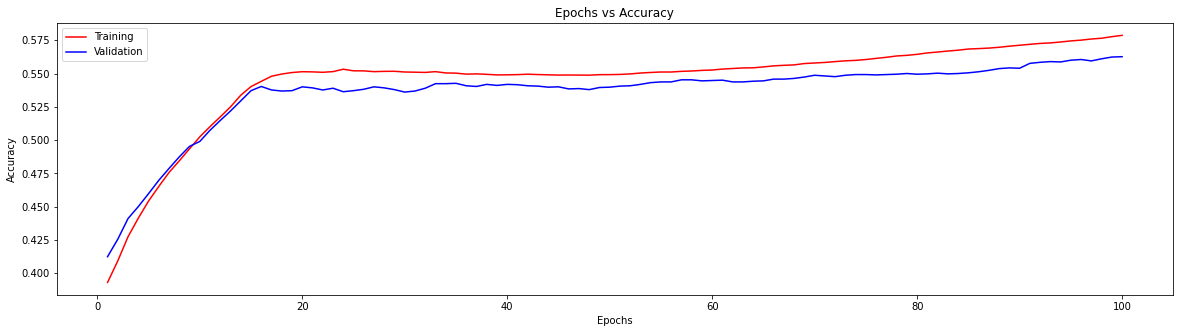

In [38]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_accuracy, "red")
plt.plot(test_epochs, test_accuracy, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

### F1 graph

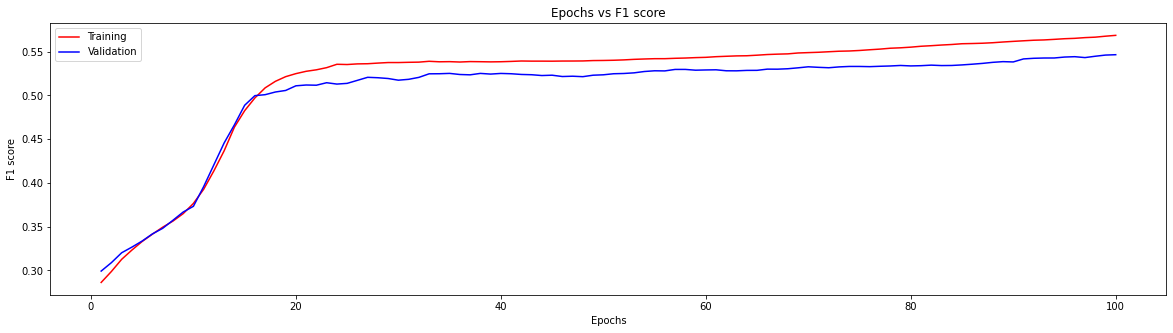

In [39]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_f1, "red")
plt.plot(test_epochs, test_f1, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("Epochs vs F1 score")
plt.show()

## Compare results of the model

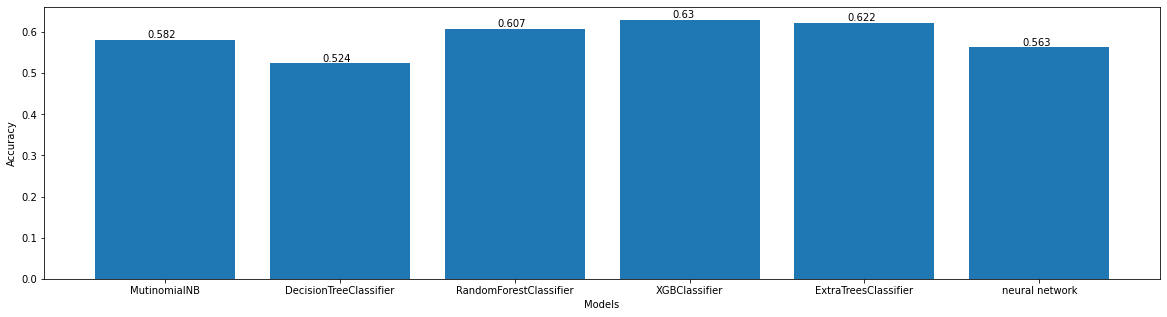

In [40]:
# Compare accuracy on test data
labels = list(tfidf_accuracy.keys()) + ["neural network"]
accuracy = list(tfidf_accuracy.values()) + [test_accuracy[-1]]
plt.bar(labels, accuracy)
plt.xlabel("Models")
plt.ylabel("Accuracy")
for idx, val in enumerate(accuracy):
    plt.text(idx-0.1, val+0.005, str(round(val, 3)))
plt.show()

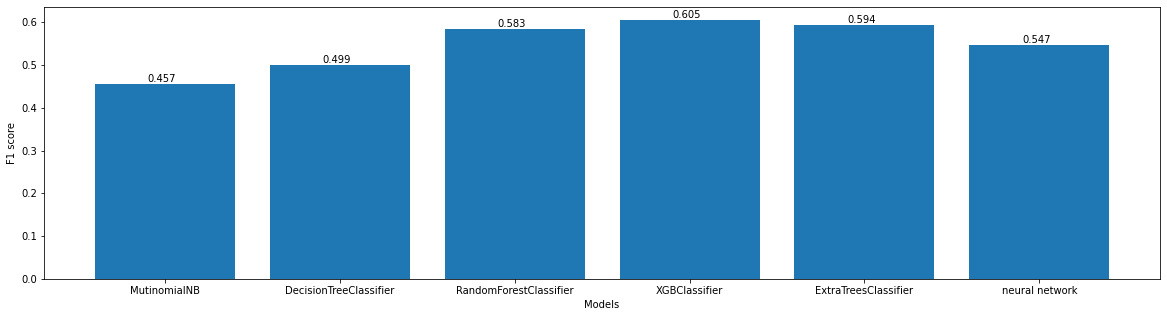

In [41]:
# Compare F1 scores on test data
f1 = list(tfidf_f1.values()) + [test_f1[-1]]
plt.bar(labels, f1)
plt.xlabel("Models")
plt.ylabel("F1 score")
for idx, val in enumerate(f1):
    plt.text(idx-0.1, val+0.005, str(round(val, 3)))
plt.show()


# Hashing Vectors

### Data Vectorization

#### Main Objective of this step is to convert the sequence to tokens to feature vector of fixed size

The following steps are carried out
1. The lemmatized sequence is vectorized using Hashing vectorizer

We will obtain
1. Vectorized training data of fixed size
2. Vectorized test data of fixed size

In [42]:
# Initialize Hashing Vectorizer
vectorizer = HashingVectorizer(n_features=300)

In [43]:
# Vectorize the sequence data
encoded_train_X = vectorizer.fit_transform(train_X)
encoded_test_X = vectorizer.transform(test_X)
print(encoded_train_X.shape, encoded_test_X.shape)

(41157, 300) (3798, 300)


## Model Training

#### The following machine learning models are trained using the vectorized data
1. Decision Tree Classifier
2. Random Forest Classifier
3. XGBoost Classifier
4. Extra Trees Classifier

In [44]:
# Place holders to store the results
hash_accuracy = {}
hash_f1 = {}

In [45]:
# Train Decision Tree classifier model
model = DecisionTreeClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
hash_accuracy["DecisionTreeClassifier"] = report["accuracy"]
hash_f1["DecisionTreeClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.50      0.52      0.51      1546
           1       0.52      0.47      0.50      1633
           2       0.32      0.36      0.34       619

    accuracy                           0.47      3798
   macro avg       0.45      0.45      0.45      3798
weighted avg       0.48      0.47      0.48      3798



In [46]:
# Train Random Forest Model
model = RandomForestClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
hash_accuracy["RandomForestClassifier"] = report["accuracy"]
hash_f1["RandomForestClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.53      0.71      0.61      1546
           1       0.63      0.50      0.56      1633
           2       0.57      0.40      0.47       619

    accuracy                           0.57      3798
   macro avg       0.58      0.54      0.54      3798
weighted avg       0.58      0.57      0.56      3798



In [47]:
# Train XGBoost Model
model = XGBClassifier(use_label_encoder=False)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
hash_accuracy["XGBClassifier"] = report["accuracy"]
hash_f1["XGBClassifier"] = report["macro avg"]['f1-score']

[07:18:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.57      0.70      0.63      1546
           1       0.65      0.57      0.61      1633
           2       0.57      0.44      0.49       619

    accuracy                           0.60      3798
   macro avg       0.60      0.57      0.58      3798
weighted avg       0.60      0.60      0.60      3798



In [48]:
# Train Extra trees classifier model
model = ExtraTreesClassifier(class_weight=class_weights)
model.fit(encoded_train_X, train_y)
pred_y = model.predict(encoded_test_X)
print(classification_report(test_y, pred_y))

# Store the results
report = classification_report(test_y, pred_y, output_dict=True)
hash_accuracy["ExtraTreesClassifier"] = report["accuracy"]
hash_f1["ExtraTreesClassifier"] = report["macro avg"]['f1-score']

              precision    recall  f1-score   support

           0       0.54      0.73      0.62      1546
           1       0.64      0.52      0.58      1633
           2       0.63      0.36      0.46       619

    accuracy                           0.58      3798
   macro avg       0.60      0.54      0.55      3798
weighted avg       0.60      0.58      0.58      3798



## Neural network training

#### A simple neural network with one hidden layer is trained using the vectorized data

In [49]:
# Convert the vectors to tensors
tensor_train_X = torch.tensor(encoded_train_X.toarray(), dtype=torch.float, device=device)
tensor_test_X = torch.tensor(encoded_test_X.toarray(), dtype=torch.float, device=device)

In [50]:
class HashClassifier(nn.Module):
  """
  Covid tweet classifer for Hash vectorized data
  """
  def __init__(self, embedding_size, hidden_size=50, n_class=3):
    """
    Intialize the hidden layers
    """
    super().__init__()
    self.fc = nn.Linear(embedding_size, hidden_size)
    self.act = nn.ReLU()
    self.out = nn.Linear(hidden_size, n_class)

  def forward(self, data):
    """
    Pass the input through the model and return the output tensor
    """
    out = self.act(self.fc(data))
    out = self.out(out)

    return out

In [60]:
# Intialize the model, loss function and optimizer

learning_rate = 0.001
n_epochs = 100
test_interval = 1

classifier_hash = HashClassifier(encoded_train_X.shape[1]).to(device)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor(list(class_weights.values())).to(device))
optimizer = torch.optim.Adam(classifier_hash.parameters(), lr=learning_rate)

In [61]:
# Placeholders to store model progress
train_loss = []
train_accuracy = []
train_f1 = []
test_loss = []
test_accuracy = []
test_f1 = []

pbar = tqdm(range(1, n_epochs+1))
for epoch in pbar:

    ##########
    # TRAINING
    ##########

    classifier_hash.train()
    
    # Get the model output
    out = classifier_hash(tensor_train_X)
    pred_values = torch.argmax(out, dim=1)

    # Calculate the loss
    loss = criterion(out, torch.tensor(train_y))
    
    # Store the training metrics
    train_loss.append(loss.detach().item())
    train_accuracy.append(accuracy_score(train_y, pred_values))
    train_f1.append(f1_score(train_y, pred_values, average='macro'))
    
    # Update the model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # print the progress
    pbar.set_description(f"Epoch:{epoch} Training loss:{round(train_loss[-1], 5)} " +
                                 f"accuracy:{round(train_accuracy[-1], 5)} " +
                                 f"f1 score:{round(train_f1[-1], 5)}")
      
    
    

    ############
    # VALIDATION
    ############
    if epoch % test_interval == 0:

        classifier_tfidf.eval()
        with torch.no_grad():
            
            # Get the model output
            out = classifier_hash(tensor_test_X)
            pred_values = torch.argmax(out, dim=1)

            # Calculate the loss
            loss = criterion(out, torch.tensor(test_y))
            
            # Store the test metrics
            test_loss.append(loss.detach().item())
            test_accuracy.append(accuracy_score(test_y, pred_values))
            test_f1.append(f1_score(test_y, pred_values, average='macro'))

Epoch:100 Training loss:0.96752 accuracy:0.53031 f1 score:0.52063: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


### Loss graph

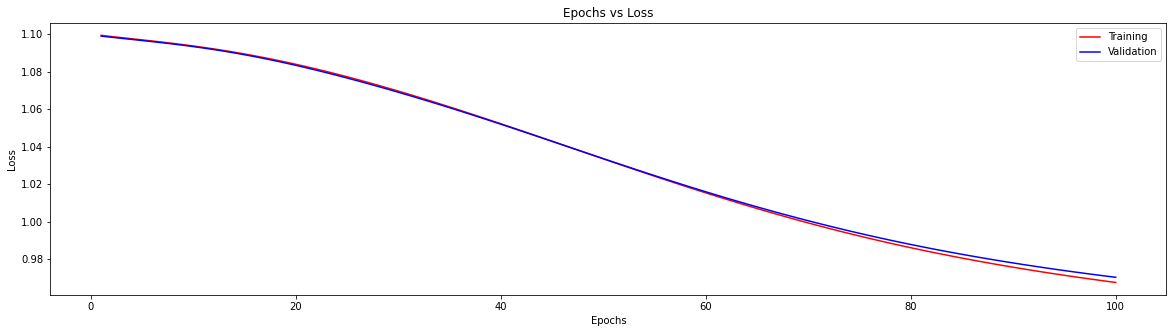

In [62]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_loss, "red")
plt.plot(test_epochs, test_loss, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.show()

### Accuracy graph

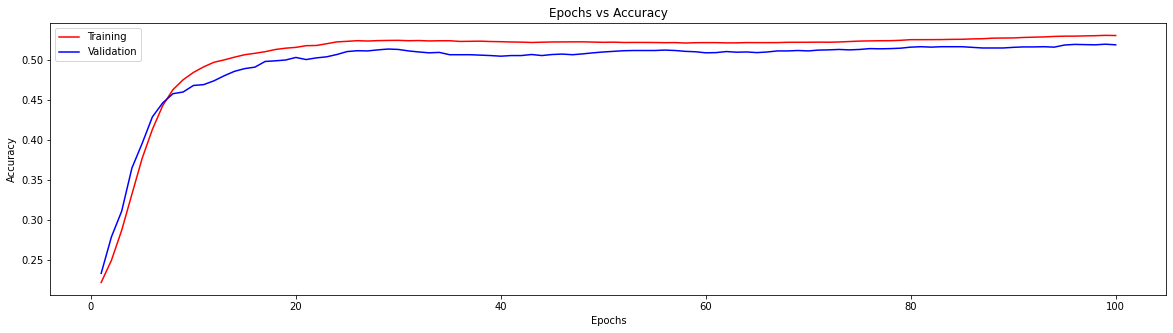

In [63]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_accuracy, "red")
plt.plot(test_epochs, test_accuracy, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs Accuracy")
plt.show()

### F1 graph

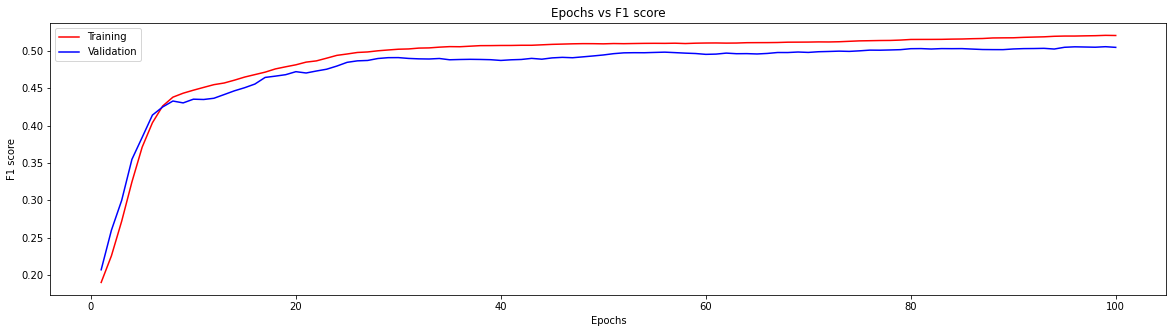

In [64]:
train_epochs = list(range(1, n_epochs+1))
test_epochs = list(range(test_interval, n_epochs+1, test_interval))
plt.plot(train_epochs, train_f1, "red")
plt.plot(test_epochs, test_f1, "blue")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("F1 score")
plt.title("Epochs vs F1 score")
plt.show()

## Compare results of the model

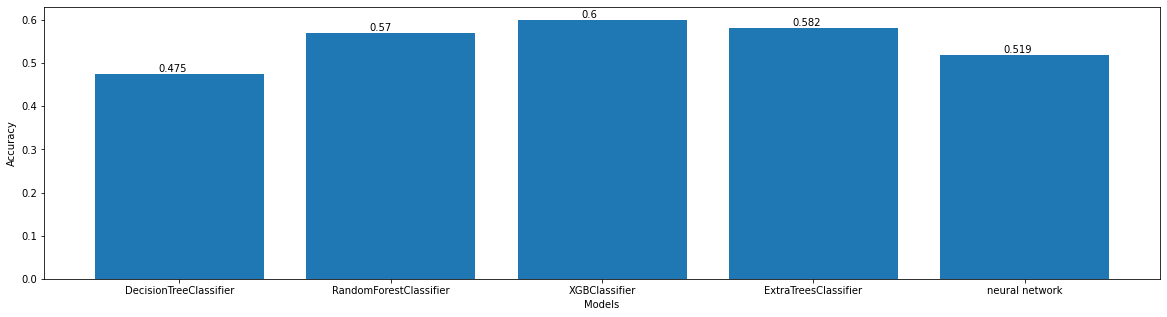

In [65]:
# Compare accuracy on test data
labels = list(hash_accuracy.keys()) + ["neural network"]
accuracy = list(hash_accuracy.values()) + [test_accuracy[-1]]
plt.bar(labels, accuracy)
plt.xlabel("Models")
plt.ylabel("Accuracy")
for idx, val in enumerate(accuracy):
    plt.text(idx-0.1, val+0.005, str(round(val, 3)))
plt.show()

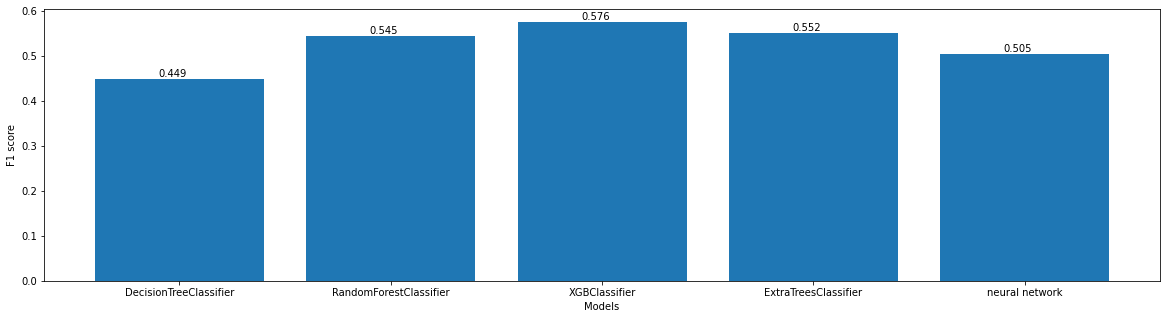

In [66]:
# Compare F1 Score on test data
f1 = list(hash_f1.values()) + [test_f1[-1]]
plt.bar(labels, f1)
plt.xlabel("Models")
plt.ylabel("F1 score")
for idx, val in enumerate(f1):
    plt.text(idx-0.1, val+0.005, str(round(val, 3)))
plt.show()


## CONCLUSION

1. The models trained above are just baseline models. We need to train a more complex model to get better performance.
2. TF-IDF vectors and Hashing vectors does not contain enough data to learn the context.
3. The number of samples of neutral class is very less hence it is likely that the model will not perform well on neutral samples.
4. We need to use better embedding techniques like GloVe and Word2Vec which can capture more features.
5. A more complex model is required to obtain better results. A model with embedding layer followed by LSTM would be an appropriate network to train this data.